In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
import os, itertools, random
from IPython.display import SVG
from tensorflow.keras.utils import plot_model, model_to_dot
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (Conv1DTranspose,Add,Attention,Multiply,LeakyReLU, Input, Conv1D, Dropout, Activation, BatchNormalization, MaxPooling1D, ZeroPadding1D, AveragePooling1D, Flatten, LSTM, Dense)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, Callback, EarlyStopping

In [3]:
#Define and import Data
df_train = pd.read_excel(r'/content/sample_data/Data2.xlsx')

In [4]:
df_train.head()

,P,TAVG,THA,THB,TCA,TCB,PSGA,PSGB,VOL,LVPZ,LSGA,LSGB,Label
0,155.000000,301.000000,320.501312,320.501312,281.498688,281.498688,54.999954,54.999954,192.994995,56.500000,11.830001,11.830001,0
1,154.995407,300.993683,320.500366,320.500366,281.497986,281.497986,54.999592,54.999592,192.994370,56.500000,11.829999,11.829999,0
2,154.988571,300.987823,320.497955,320.497955,281.496918,281.496918,54.998913,54.998913,192.992157,56.492828,11.830001,11.830001,0
3,154.966904,300.970520,320.481750,320.481750,281.490326,281.490326,54.994022,54.994022,192.983582,56.453777,11.830014,11.830014,0
4,154.963882,300.968018,320.477600,320.477600,281.488403,281.488403,54.992538,54.992538,192.982269,56.447338,11.830022,11.830022,0


In [5]:
#Define the training and test sample
train_x=df_train.drop('Label', axis=1)
train_y=df_train['Label']


In [6]:
X_train, X_test, y_train, y_test =train_test_split (train_x, train_y, test_size =0.3, random_state =0)
print('train data shape: %r, train target shape: %r' %(X_train.shape, y_train.shape))
print('test data shape: %r, test target shape: %r' %(X_test.shape, y_test.shape))

train data shape: (10500, 12), train target shape: (10500,)
test data shape: (4500, 12), test target shape: (4500,)


In [7]:
#convert to numpy array and reshape in 3D
X_train= X_train.to_numpy()
y_train= y_train.to_numpy()
X_test = X_test.to_numpy()
y_test= y_test.to_numpy()
X_train= X_train.reshape((X_train.shape[0],-1, 12)).astype(np.float32)
y_train = y_train.reshape((y_train.shape[0],1)).astype(np.float32)
X_test= X_test.reshape((X_test.shape[0],-1,12)).astype(np.float32)
y_test = y_test.reshape((y_test.shape[0],1)).astype(np.float32)

In [8]:
print('new train data shape: %r, train target shape: %r' %(X_train.shape, y_train.shape))

new train data shape: (10500, 1, 12), train target shape: (10500, 1)


In [9]:
print('new test data shape: %r, test target shape: %r' %(X_test.shape, y_test.shape))

new test data shape: (4500, 1, 12), test target shape: (4500, 1)


In [10]:
#One-hot encode the labels
y_train = to_categorical(y_train)
y_test= to_categorical(y_test)

In [11]:
class_names = (['NormalOperation','SGTR', 'LOCA', 'LACP', 'SLBIC'])

class_name_labels = {class_name:i for i,class_name in enumerate(class_names)}

num_classes = len(class_names)
class_name_labels

{'LACP': 3, 'LOCA': 2, 'NormalOperation': 0, 'SGTR': 1, 'SLBIC': 4}

In [12]:
nb_features = X_train.shape[2]
nb_out = y_train.shape[1]
sequence_length=X_train.shape[1]

In [13]:
#Creat model

In [14]:
n_filters = 32
filter_width = 2
n_features = nb_features
dilation_rates = [1, 2,3]

history_seq = Input(shape=(sequence_length,nb_features))
x = history_seq

skips = []
for dilation_rate in dilation_rates:

    # preprocessing - equivalent to time-distributed dense
    x = Conv1D(16, 1, padding='same', activation="relu")(x)
    

    # filter
    x_f = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='same',
                 dilation_rate=dilation_rate)(x)
    x_f = LeakyReLU()(x_f)
    x_f = BatchNormalization()(x_f)

    # gate
    x_g = Conv1D(filters=n_filters,
                 kernel_size=filter_width, 
                 padding='same',
                 dilation_rate=dilation_rate)(x)
    # combine filter and gating branches
    z = Multiply()([Activation('tanh')(x_f),
                    Activation('sigmoid')(x_g)])

    # postprocessing - equivalent to time-distributed dense
    z = Conv1D(16, 1, padding='same',activation="relu")(z)

    # residual connection
    x = Add()([x, z])    

    # collect skip connections
    skips.append(z)

# add all skip connection outputs 
out = Activation('relu')(Add()(skips))

out = Flatten()(out)

#Final dense layer
out= Dense (5,activation="softmax")(out)

model = Model(history_seq,out)
optimizer = tensorflow.keras.optimizers.Adam(learning_rate=3e-5)

model.compile(loss= "categorical_crossentropy",optimizer=optimizer,metrics=('accuracy'))

In [15]:
#View model architecture

plot_model(model,to_file='basic_model.png')
SVG(model_to_dot(model).create(prog='dot',format='svg'))

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1, 12)]      0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1, 16)        208         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1, 32)        1056        conv1d[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 1, 32)        0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [16]:
# Get the graph of the model and save it
tensorflow.keras.utils.plot_model(model, show_shapes=True, to_file='Wavenet.png',dpi=300)

In [17]:
#specify checkpoints and early stopping criteria to avoid overfitting
checkpoint = ModelCheckpoint("model_weights.h5",monitor='val_accuracy',verbose=1,save_best_only=True,mode='max')

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [18]:
#Train the model
epochs = 500
batch_size = 16

train_history = model.fit(X_train, y_train,
                   steps_per_epoch=len(X_train)//batch_size,
                   epochs=epochs,
                   verbose=1,validation_split=0.2, callbacks=[checkpoint, early_stopping])

Epoch 1/500
656/656 [==============================] - 5s 5ms/step - loss: 1.5309 - accuracy: 0.3858 - val_loss: 1.3606 - val_accuracy: 0.5600

Epoch 00001: val_accuracy improved from -inf to 0.56000, saving model to model_weights.h5
Epoch 2/500
 23/656 [>.............................] - ETA: 2s - loss: 1.3735 - accuracy: 0.5217

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


656/656 [==============================] - 3s 4ms/step - loss: 1.2839 - accuracy: 0.6154 - val_loss: 1.1893 - val_accuracy: 0.7076

Epoch 00002: val_accuracy improved from 0.56000 to 0.70762, saving model to model_weights.h5
Epoch 3/500
656/656 [==============================] - 3s 5ms/step - loss: 1.1150 - accuracy: 0.7426 - val_loss: 1.0560 - val_accuracy: 0.8410

Epoch 00003: val_accuracy improved from 0.70762 to 0.84095, saving model to model_weights.h5
Epoch 4/500
656/656 [==============================] - 3s 4ms/step - loss: 0.9748 - accuracy: 0.8003 - val_loss: 0.8899 - val_accuracy: 0.8119

Epoch 00004: val_accuracy did not improve from 0.84095
Epoch 5/500
656/656 [==============================] - 3s 4ms/step - loss: 0.8579 - accuracy: 0.8193 - val_loss: 0.7653 - val_accuracy: 0.8157

Epoch 00005: val_accuracy did not improve from 0.84095
Epoch 6/500
656/656 [==============================] - 3s 4ms/step - loss: 0.7391 - accuracy: 0.8393 - val_loss: 0.6640 - val_accuracy: 0.88

In [19]:
#This finction plots the training and validation losses
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    ax[0].plot(history.history['loss'],label='Train Loss')
    ax[0].plot(history.history['val_loss'],label='Validation Loss')
    ax[1].plot(history.history['accuracy'],label='Train Accuracy')
    ax[1].plot(history.history['val_accuracy'],label='Validation Accuracy')
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    plt.show();
    pass

In [20]:
#This function plots the confusion matrix
def plot_confusion_matrix(cm,classes,title='Confusion Matrix',cmap=plt.cm.Blues):
    
#   np.seterr(divide='ignore',invalid='ignore')
    cm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = '.2f'
    thresh = cm.max()/2.
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        pass
    
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    pass

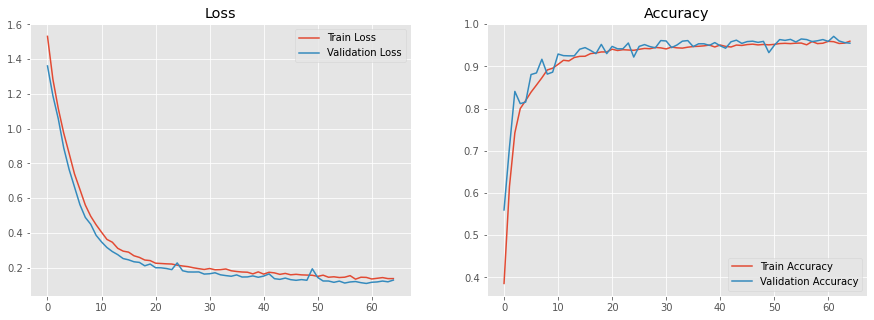

In [21]:
show_final_history(train_history)

In [22]:
#Now use the trained model for prediction
test_pred = model.predict(X_test)
test_pred = np.argmax(test_pred,axis=1)

<Figure size 432x288 with 0 Axes>

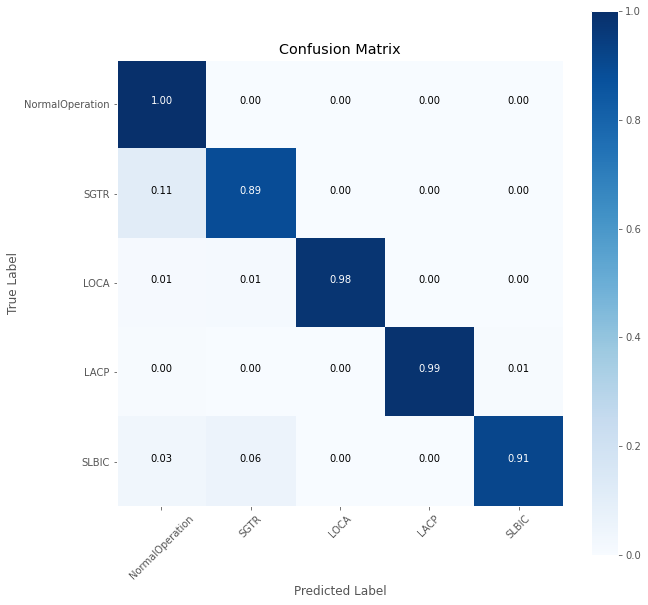

In [23]:
#plot the confusion matrix
test_actual = np.argmax(y_test,axis=1)
cnf_mat = confusion_matrix(test_actual, test_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_mat,classes=class_names)
plt.grid(None)
plt.show();

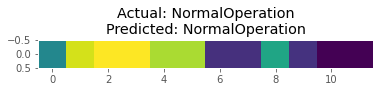

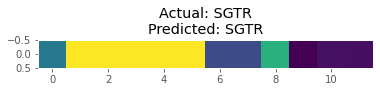

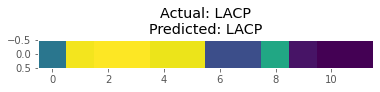

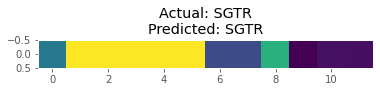

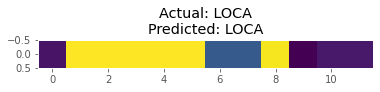

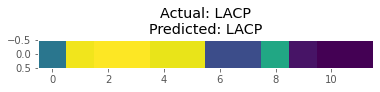

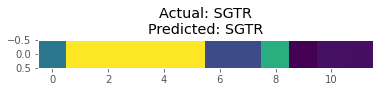

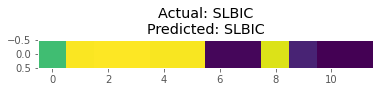

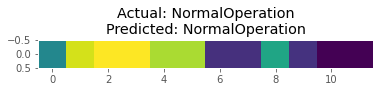

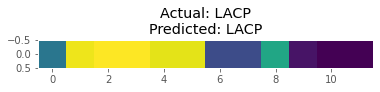

In [24]:
#Another view of the prediction output
rnd_idx = random.sample(range(0,40),10)

class_labels = {i:class_name for (class_name,i) in class_name_labels.items()}
class_labels

# fig, ax = plt.subplots(2,5,figsize=(5,5))

for i,idx in enumerate(rnd_idx):
    
    plt.imshow(X_test[idx])
    plt.title("Actual: {}\nPredicted: {}".format(class_labels[test_actual[idx]],class_labels[test_pred[idx]]))
    plt.grid(None)
    plt.show()
    pass